In [6]:
import os
import cv2
import numpy as np

# Function to list all image file paths recursively in a directory
def list_image_files(directory):
    paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png')):
                paths.append(os.path.join(root, file))
    return paths

def calculate_mean_std(directory):
    image_paths = list_image_files(directory)
    pixel_values = []

    # Read and store pixel values of each image
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
        pixels = image.flatten()
        pixel_values.extend(pixels)

    # Convert pixel_values to a NumPy array
    pixel_values = np.array(pixel_values, dtype=np.float32)

    # Calculate mean and standard deviation
    mean = np.mean(pixel_values)
    std = np.std(pixel_values)
    max_pixel, min_pixel = max(pixel_values), min(pixel_values)

    return mean, std, max_pixel, min_pixel

# Replace 'your_directory' with the path to your dataset directory
mean, std, max_pixel, min_pixel = calculate_mean_std('mel_spectrogram')
print(f'Mean: {mean}, Standard Deviation: {std}, Max: {max_pixel}, Min: {min_pixel}')



Mean: 112.28450012207031, Standard Deviation: 46.1202507019043, Max: 255.0, Min: 0.0


In [7]:
normalized_mean = (mean-min_pixel)/(max_pixel-min_pixel)
normalized_std = (std)/(max_pixel-min_pixel)

print(f'Mean: {normalized_mean}, Standard Deviation: {normalized_std}')

Mean: 0.440331369638443, Standard Deviation: 0.18086372315883636


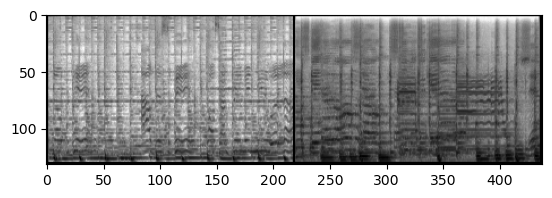

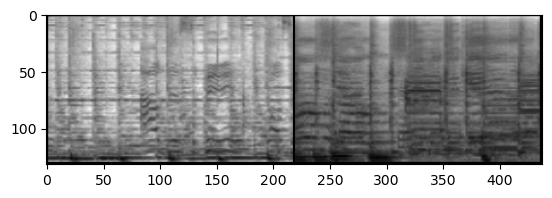

In [19]:
from dataset import CustomImageDataset
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from random import random

import augmentations

import torch.nn as nn

from torchvision.models import resnet18

from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

torch.manual_seed(43)

def augmentation_pipeline(image_size=(128, 216), alpha=0.1):
    pipeline = nn.Sequential(
        # augmentations.MixUpAugmentation(alpha=alpha),
        transforms.RandomApply([transforms.RandomResizedCrop(size=image_size, scale=(0.5, 1), antialias=False)], p=1),
        # augmentations.post_normalize()
    )
    return pipeline

mean = 0.4403
std = 0.1809
transform = transforms.Compose([
    # transforms.Resize((216, 128)),
    transforms.ToTensor(),
    # transforms.Normalize([mean], [std])
    ])

root_dir = './mel_spectrogram'
batch_size = 2

# Create the custom dataset
dataset = CustomImageDataset(root_dir, transform=transform)

# Split the dataset into train and validation sets (optional)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Create DataLoaders for the train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

pipeline = augmentation_pipeline(alpha=1, image_size=(128, 216))

data_iter = iter(train_dataloader)
images, _ = next(data_iter)
augmented_images = pipeline(images)

# print(images.mean())

# Visualize the original and augmented images

grid_img = torchvision.utils.make_grid(images, nrow=5)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
grid_aug = torchvision.utils.make_grid(augmented_images, nrow=5)
plt.imshow(grid_aug.permute(1, 2, 0), vmax=1, vmin=0)
plt.show()

In [21]:
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image


spectrogram_path = './mel_spectrogram/blues/blues.00000_segment1.png'
spectrogram = np.array(Image.open(spectrogram_path))

pil_spectrogram = to_pil_image(spectrogram)

# Get the dimensions
F, T = pil_spectrogram.size

print(F)
print(T)

216
128
